**motivation**<br>
Bootstrapping strikes me as getting something out of nothing. Given a training set, we can fit a learning algorithm on the training set directly, or we can repeatedly sample from the training set (with replacement), fit the algorithm on one sample at a time, then average the results across all samples. The second approach is not using any new information relative to the first, yet it may outperform the first in terms of test set error. In this notebook I want to see how this happens, in the context of decision trees with bagging.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.core.display import HTML

In [2]:
# create some points that satisfy a sine relationship
P = 100
x = np.linspace(-1, 1, num=P)
y = np.sin(math.pi*x)

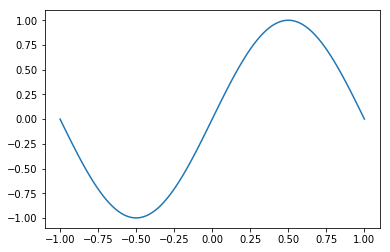

In [3]:
# plot these points
plt.plot(x,y)
plt.show()

**1. one-off comparison between the first approach and the second approach**

In [4]:
# set up train data and test data
sample_size = 20
sample = np.random.choice(list(range(100)), sample_size, replace = False).tolist()
train_sample_size = int(0.8*sample_size)
train_sample = np.random.choice(sample, int(0.8*sample_size), replace = False).tolist()
test_sample = list(set(sample) - set(train_sample))
train_x = x[train_sample]
train_y = y[train_sample]
train_data = pd.DataFrame()
train_data['x'] = train_x
train_data['y'] = train_y
test_x = x[test_sample]
test_y = y[test_sample]
test_data = pd.DataFrame()
test_data['x'] = test_x
test_data['y'] = test_y

# fit a decision tree on the train data directly, then calculate test set error
regressor = DecisionTreeRegressor(random_state=0, max_depth=2)
regressor.fit(train_data.drop(['y'], axis=1), train_data['y'])
test_data['pred'] = regressor.predict(test_data[['x']])
SSR = ((test_data['pred'] - test_data['y'])**2).sum()

# from the train data, create N bootstrapped samples 
# train a tree on each one of them, average all predictions to get final prediction
# the size of each bootstrapped sample is the same as train_sample_size, but the sampling is with replacement
N = 10
test_pred = np.zeros(test_data.shape[0])
for i in range(N):
    c = np.random.choice(train_sample, train_sample_size, replace = True) # bootstrapped sample
    train_x = x[c]
    train_y = y[c]
    train_data = pd.DataFrame()
    train_data['x'] = train_x
    train_data['y'] = train_y
    regressor = DecisionTreeRegressor(random_state=0, max_depth=2)
    regressor.fit(train_data.drop(['y'], axis=1), train_data['y'])
    test_pred = test_pred + regressor.predict(test_data[['x']])
test_data['y'] = test_y
test_data['pred'] = test_pred/N
SSR_1 = ((test_data['pred'] - test_data['y'])**2).sum()
SSR, SSR_1

(1.4817020020649645, 0.5863530411254183)

**2. repeated comparison between the first approach and the second approach**

In [5]:
# we might get lucky (or unlucky) in the one-off comparison above
# repeat the one-off comparison 5000 times
M = 5000
N = 10
sample_size = 20
SSR = []
SSR_1 = []
for j in range(M):
    if j%1000 == 0:
        print(j)
    train_sample_size = int(0.8*sample_size)
    sample = np.random.choice(list(range(100)), sample_size, replace = False).tolist()
    train_sample = np.random.choice(sample, int(0.8*sample_size), replace = False).tolist()
    test_sample = list(set(sample) - set(train_sample))
    train_x = x[train_sample]
    train_y = y[train_sample]
    train_data = pd.DataFrame()
    train_data['x'] = train_x
    train_data['y'] = train_y
    test_x = x[test_sample]
    test_y = y[test_sample]
    test_data = pd.DataFrame()
    test_data['x'] = test_x
    test_data['y'] = test_y
    
    # fit a tree on train data
    regressor = DecisionTreeRegressor(random_state=0, max_depth=2)
    regressor.fit(train_data.drop(['y'], axis=1), train_data['y'])

    # calculate test set error
    test_data['pred'] = regressor.predict(test_data[['x']])
    SSR.append(((test_data['pred'] - test_data['y'])**2).sum())    

    # do bagging
    test_pred = np.zeros(test_data.shape[0])
    for i in range(N):
        c = np.random.choice(train_sample, train_sample_size, replace = True) # bootstrapped sample
        train_x = x[c]
        train_y = y[c]
        train_data = pd.DataFrame()
        train_data['x'] = train_x
        train_data['y'] = train_y
        regressor = DecisionTreeRegressor(random_state=0, max_depth=2)
        regressor.fit(train_data.drop(['y'], axis=1), train_data['y'])
        test_pred = test_pred + regressor.predict(test_data[['x']])
    test_data['y'] = test_y
    test_data['pred'] = test_pred/N
    SSR_1.append(((test_data['pred'] - test_data['y'])**2).sum())

0
1000
2000
3000
4000


In [6]:
# compare the average errors
sum(SSR)/len(SSR), sum(SSR_1)/len(SSR_1)

(0.37504132700826626, 0.2713623618824676)

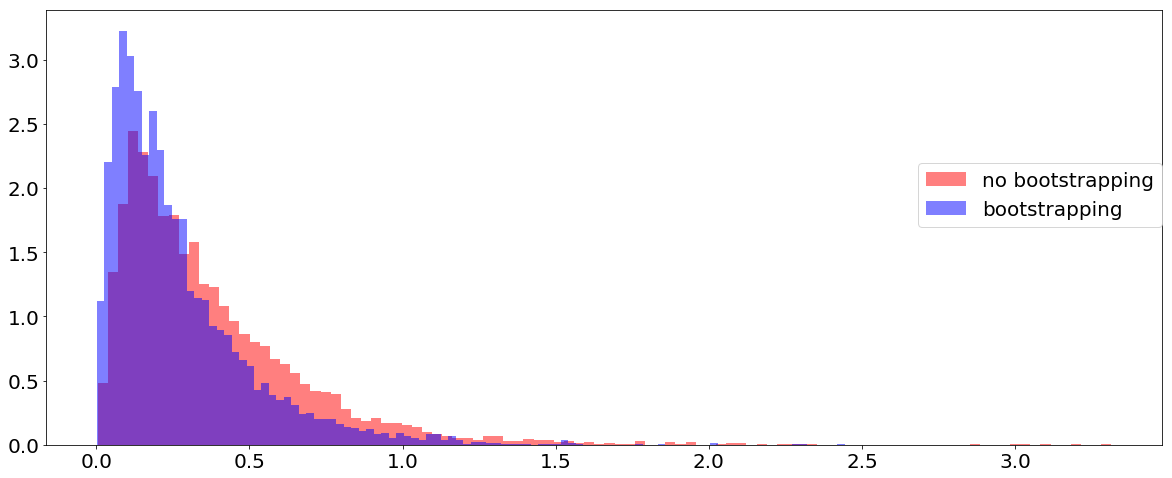

In [7]:
ssr = np.array(SSR)
ssr_1 = np.array(SSR_1)
plt.rcParams['figure.figsize'] = (20.0, 8.0)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
bins = 100
plt.hist(ssr, bins=bins, alpha=0.5, color = 'r', normed=True, label='no bootstrapping')
plt.hist(ssr_1, bins=bins, alpha=0.5, color = 'b', normed=True, label='bootstrapping')
plt.legend(bbox_to_anchor=(1,0.5),loc='lower right',borderaxespad=0.,fontsize=20)
plt.show()

**discussion**<br>
The above simulation suggests that bootstrapping is useful with trees. I suspect that it is not useful with linear regression. The difference between the two is linearity. If the model is linear, the average model from the bootstrapped training examples are going to be close to the model trained on the training set directly. Averaging adds little value. With trees, however, the average model from the bootstrapped training examples are not going to be close to the model trained on the training set directly. Averaging does make a difference. To get something out of nothing, non-linearity is necessary.